# Example of multivariate imputation using a linear regression model
#### Here is the original [source](https://www.kaggle.com/residentmario/simple-techniques-for-missing-data-imputation) for the example

In [5]:
import missingno as msno ## specific python lib to analyse missingness

In [6]:
import pandas as pd
pd.set_option('max_columns', None)
df = pd.read_csv("https://raw.githubusercontent.com/PaoloMissier/CSC3831-2021-22/main/IMPUTATION/BEERS-dataset/recipeData.csv", na_values = ['N/A'], encoding='latin-1').set_index("BeerID")

In [7]:
df.columns

Index(['Name', 'URL', 'Style', 'StyleID', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU',
       'Color', 'BoilSize', 'BoilTime', 'BoilGravity', 'Efficiency',
       'MashThickness', 'SugarScale', 'BrewMethod', 'PitchRate', 'PrimaryTemp',
       'PrimingMethod', 'PrimingAmount', 'UserId'],
      dtype='object')

## part I: analysing missingness

In [8]:
## shape of original dataframe
df.head(50)

,Name,URL,Style,StyleID,Size(L),OG,FG,ABV,IBU,Color,BoilSize,BoilTime,BoilGravity,Efficiency,MashThickness,SugarScale,BrewMethod,PitchRate,PrimaryTemp,PrimingMethod,PrimingAmount,UserId
BeerID,,,,,,,,,,,,,,,,,,,,,,
1,Vanilla Cream Ale,/homebrew/recipe/view/1633/vanilla-cream-ale,Cream Ale,45,21.77,1.0550,1.0130,5.48,17.65,4.83,28.39,75,1.038,70.0,NaN,Specific Gravity,All Grain,NaN,17.78,corn sugar,4.5 oz,116.0
2,Southern Tier Pumking clone,/homebrew/recipe/view/16367/southern-tier-pumk...,Holiday/Winter Special Spiced Beer,85,20.82,1.0830,1.0210,8.16,60.65,15.64,24.61,60,1.070,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,955.0
3,Zombie Dust Clone - EXTRACT,/homebrew/recipe/view/5920/zombie-dust-clone-e...,American IPA,7,18.93,1.0630,1.0180,5.91,59.25,8.98,22.71,60,NaN,70.0,NaN,Specific Gravity,extract,NaN,NaN,NaN,NaN,NaN
4,Zombie Dust Clone - ALL GRAIN,/homebrew/recipe/view/5916/zombie-dust-clone-a...,American IPA,7,22.71,1.0610,1.0170,5.80,54.48,8.50,26.50,60,NaN,70.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,NaN
5,Bakke Brygg Belgisk Blonde 50 l,/homebrew/recipe/view/89534/bakke-brygg-belgis...,Belgian Blond Ale,20,50.00,1.0600,1.0100,6.48,17.84,4.57,60.00,90,1.050,72.0,NaN,Specific Gravity,All Grain,NaN,19.00,Sukkerlake,6-7 g sukker/l,18325.0
6,Sierra Nevada Pale Ale Clone,/homebrew/recipe/view/28546/sierra-nevada-pale...,American Pale Ale,10,24.61,1.0550,1.0130,5.58,40.12,8.00,29.34,70,1.047,79.0,NaN,Specific Gravity,All Grain,1.00,NaN,NaN,NaN,5889.0
7,Russian River Pliny the Elder (original),/homebrew/recipe/view/37534/russian-river-plin...,Imperial IPA,86,22.71,1.0720,1.0180,7.09,268.71,6.33,30.28,90,NaN,75.0,NaN,Specific Gravity,All Grain,NaN,NaN,NaN,NaN,1051.0
8,Spotted Clown (New Glarus Spotted Cow clone),/homebrew/recipe/view/672/spotted-clown-new-gl...,Cream Ale,45,20.82,1.0540,1.0140,5.36,19.97,5.94,28.39,75,1.040,70.0,1.40,Specific Gravity,All Grain,NaN,NaN,corn sugar,4.2 oz,116.0
9,Chocolate Vanilla Porter,/homebrew/recipe/view/29265/chocolate-vanilla-...,Robust Porter,129,22.71,1.0600,1.0160,5.77,31.63,34.76,30.28,75,1.042,73.0,NaN,Specific Gravity,All Grain,NaN,NaN,corn sugar,4 oz,116.0


to see how many NULL values there are, we rely on `df.isnull()` from Pandas. This assumes that we have "mapped" all possible forms of NULL values to `NaN` when we loaded the dataset, i.e. using
`pd.read_csv("...", na_values = ['N/A'])` (See above)

In [11]:
print(df.shape)
## using isNull()
df.isnull().sum()

(73861, 22)


Name                 1
URL                  0
Style              596
StyleID              0
Size(L)              0
OG                   0
FG                   0
ABV                  0
IBU                  0
Color                0
BoilSize             0
BoilTime             0
BoilGravity       2990
Efficiency           0
MashThickness    29864
SugarScale           0
BrewMethod           0
PitchRate        39252
PrimaryTemp      22662
PrimingMethod    67095
PrimingAmount    69087
UserId           50490
dtype: int64

### next, we employ the [`missingno`](https://github.com/ResidentMario/missingno) library to further analyse missing data

First we look at a matrix of missing data per record and per column -- here we take a random sample of 500 records

<AxesSubplot:>

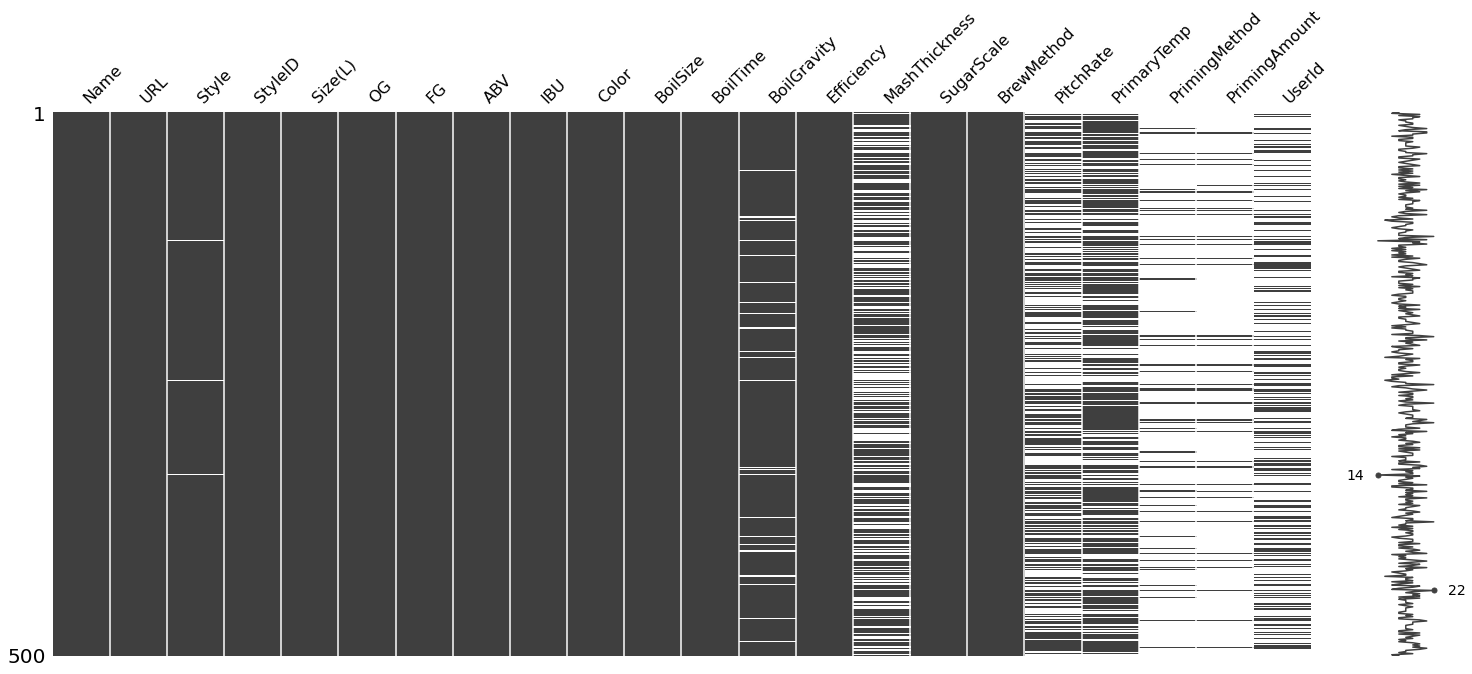

In [12]:
%matplotlib inline
msno.matrix(df.sample(500, random_state=32))

next, we plot a barchart to dsisplay missingness for each column

<AxesSubplot:>

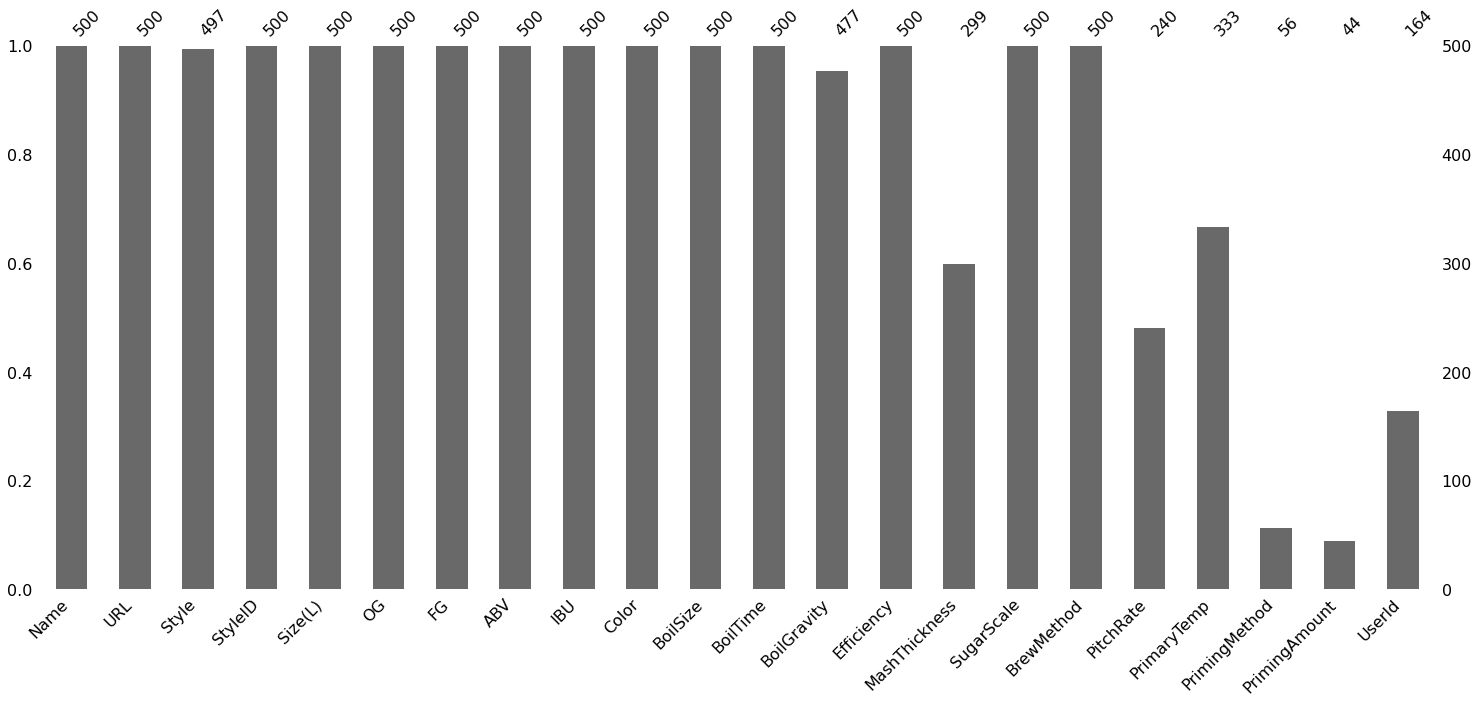

In [13]:
%matplotlib inline
msno.bar(df.sample(500, random_state=32))

### if we decided to remove all records with at least one null value, the result would be a very small training set:

In [31]:
len(df), len(df.dropna())

(73861, 757)

### can we do better?

### the next simple idea is to only remove columns with too many nulls --- we will not be able to impute or otherwise use them for modelling. As we can see from the chart and matrix above, `PrimingMethod` and `PrimingAmount` are too sparse to be used. 
check that we are left with 20 columns


In [32]:
df.shape[1], df.drop(['PrimingMethod', 'PrimingAmount'], axis='columns').shape[1]

(22, 20)

### ``MashThickness`` contains nearly 30k null values  out of 74K records

### here we simply replace all of them with the mean of the available values, and check that we no longer have any nulls

In [33]:
df['MashThickness'].isnull().sum(), df['MashThickness'].fillna(df['MashThickness'].mean()).isnull().sum()

(29864, 0)

### naturally, the mean across the column has not changed

In [34]:
df['MashThickness'].mean(), df['MashThickness'].fillna(df['MashThickness'].mean()).mean()

(2.1272352339932605, 2.127235233992244)

however, we should be aware that we have now reduced the variance. This makes for a training set that is both less realistic and also less useful


In [35]:
df['MashThickness'].std(), df['MashThickness'].fillna(df['MashThickness'].mean()).std()

(1.682347279063175, 1.2984271713674782)

## imputation by multivariate regression

### now we consider a more sophisticated approach:

### we use the remaining columns as features to train a regression model where ``MashThickness`` is the outcome, and we use the model's prediction to impute the missing values

### the plan is to use the values in columns:

### [``Style``, ``BoilGravity``, ``BrewMethod``, ``SugarScale``]

### to predict the missing values in ``MashThickness``

## preprocessing

### first we perform a one-hot encoding of the categorical variable ``Style`` 

In [36]:
beer_Style_encoded = (pd.get_dummies(df['Style']))

### next we create a list of the beer styles that occur in more than 10% of the dataset

In [37]:
frequent_styles = beer_Style_encoded.sum(axis='rows') > (len(df) / 100)

In [38]:
## this is a just trick to turn all the False values into NaN, then remove the records with those NaN values.
## this leaves us with an array of the most popular beer styles

popular_beer_styles = frequent_styles.where(lambda v: v).dropna().index.values
popular_beer_styles

array(['American Amber Ale', 'American Brown Ale', 'American IPA',
       'American Light Lager', 'American Pale Ale', 'American Porter',
       'American Stout', 'Blonde Ale', 'California Common Beer',
       'Cream Ale', 'Double IPA', 'English IPA', 'Imperial IPA',
       'Irish Red Ale', 'Kölsch', 'Oatmeal Stout', 'Robust Porter',
       'Russian Imperial Stout', 'Saison', 'Sweet Stout', 'Weissbier',
       'Weizen/Weissbier', 'Witbier'], dtype=object)

### now we drop columns that we are not going to use for modelling

In [39]:
dfc = (df.drop(['PrimingMethod', 'PrimingAmount', 'UserId', 'PitchRate', 'PrimaryTemp', 'StyleID', 'Name', 'URL'], axis='columns'))
       
print (dfc.columns)
print(len(dfc))

Index(['Style', 'Size(L)', 'OG', 'FG', 'ABV', 'IBU', 'Color', 'BoilSize',
       'BoilTime', 'BoilGravity', 'Efficiency', 'MashThickness', 'SugarScale',
       'BrewMethod'],
      dtype='object')
73861


### drop all records where BoilGravity is null

In [40]:
dfc = dfc.dropna(subset=['BoilGravity'])

len(dfc)

70871

### the rest of this prep code performs one-hot encoding of the remaining categorical variables `BrewMethod`, `SugarScale`
### note that these columns are then removed along with ``Style`` as they are replaced by the corresponding binary columns

In [41]:
dfc = dfc.pipe(lambda df: df.join(pd.get_dummies(df['BrewMethod'], prefix='BrewMethod')) \
               .pipe(lambda df: df.join(pd.get_dummies(df['SugarScale'], prefix='SugarScale'))) \
               .pipe(lambda df: df.assign(Style=df['Style'].map(lambda s: s if s in popular_beer_styles else 'Other'))) \
               .pipe(lambda df: df.join(pd.get_dummies(df['Style'], prefix='Style'))) \
               .drop(['BrewMethod', 'SugarScale', 'Style'], axis='columns'))

### finally we prepare the training set from the resulting dataframe

### ``c`` is a list of all the names of all columns except 'MashThickness'. which is our outcome
### note that we now have many more columns than at the start, because of  the multiple encodings of the cat variables

In [42]:
c = [c for c in dfc.columns if c != 'MashThickness']

c

['Size(L)',
 'OG',
 'FG',
 'ABV',
 'IBU',
 'Color',
 'BoilSize',
 'BoilTime',
 'BoilGravity',
 'Efficiency',
 'BrewMethod_All Grain',
 'BrewMethod_BIAB',
 'BrewMethod_Partial Mash',
 'BrewMethod_extract',
 'SugarScale_Plato',
 'SugarScale_Specific Gravity',
 'Style_American Amber Ale',
 'Style_American Brown Ale',
 'Style_American IPA',
 'Style_American Light Lager',
 'Style_American Pale Ale',
 'Style_American Porter',
 'Style_American Stout',
 'Style_Blonde Ale',
 'Style_California Common Beer',
 'Style_Cream Ale',
 'Style_Double IPA',
 'Style_English IPA',
 'Style_Imperial IPA',
 'Style_Irish Red Ale',
 'Style_Kölsch',
 'Style_Oatmeal Stout',
 'Style_Other',
 'Style_Robust Porter',
 'Style_Russian Imperial Stout',
 'Style_Saison',
 'Style_Sweet Stout',
 'Style_Weissbier',
 'Style_Weizen/Weissbier',
 'Style_Witbier']

### X is a dataframe containing all the feature values: the rows are those where the value of ``MashThickness`` is not null, while the columns are all those listed above

In [43]:
X = dfc[dfc['MashThickness'].notnull()].loc[:, c].values

### ``y`` is a dataframe with all records where the value of ``MashThickness`` is not null, and the single ``MashThickness`` column
### this provides the set of all labels for the training set

In [44]:
y = dfc[dfc['MashThickness'].notnull()]['MashThickness'].values
y

array([1.4 , 1.2 , 1.25, ..., 1.25, 3.  , 3.  ])

### ``yy`` contains the records where the values of ``MashThickness`` must be predicted

In [45]:
yy = dfc[dfc['MashThickness'].isnull()]['MashThickness'].values
yy

array([nan, nan, nan, ..., nan, nan, nan])

## Finally we are ready to train our _linear_ regression model using ``X`` and ``y``

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import numpy as np

np.random.seed(42)  ## this makes the model reproducible

kf = KFold(n_splits=4)  ## for k-fold validation
scores = []

## generate K=4 models, one for each fold
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    scores.append(r2_score(y_test, y_test_pred))

print(scores)

[0.012942533393265787, 0.009359944248067964, 0.00924054218885939, -0.0003957911766836464]


### the R2 values are very low, indicating that the model is very poor at predicting the missing values of `MashThickness`. 

### the following discussion is taken from the original blog entry (link at the top of thie notebook) and does a good job at explaining what conclusions we can draw from this exercise

> In this specific case the extremely low cross validation scores, all indistinguishable from 0, basically tells us that we've picked an impossible task: MashThickness cannot be determined with any accuracy from another of the other variables in the dataset (at least, if it can, then the relationship is non-linear—doubtful in this scenario). This cuts both ways, of course—if none of the variables in the dataset predict MashThickness, then MashThickness is useless for predicting anything any of them either!

> Nevertheless, for more usefully correlated columns this template of using a model of some kind to impute the column values is highly useful and makes a lot of sense from a practitioner's perspecive.

### to try and understand why the results are poor, we again use `missingno` to visulise a missingness correlation heatmap between each pair of columns.
From the documentation:  _The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another_

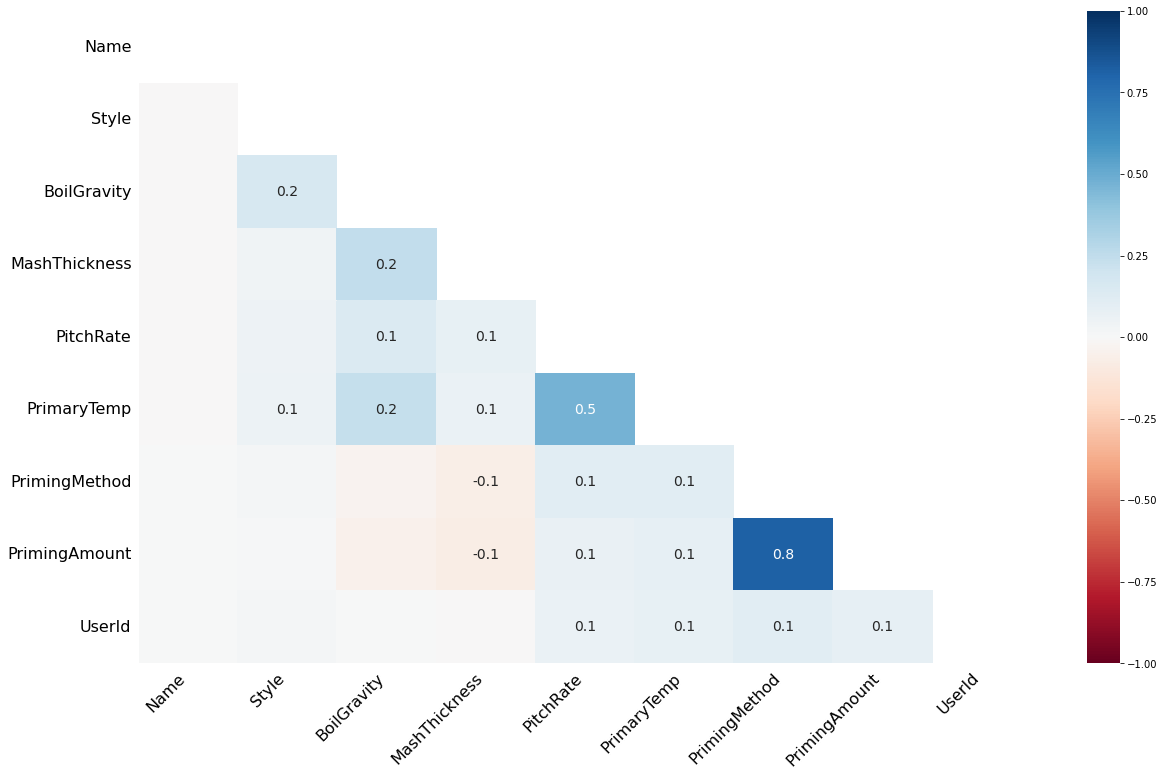

In [47]:
msno.heatmap(df)

### finally, we can also use `missingo` to generate a dendogram, using a hierarchical clustering algorithm, where  _Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on_

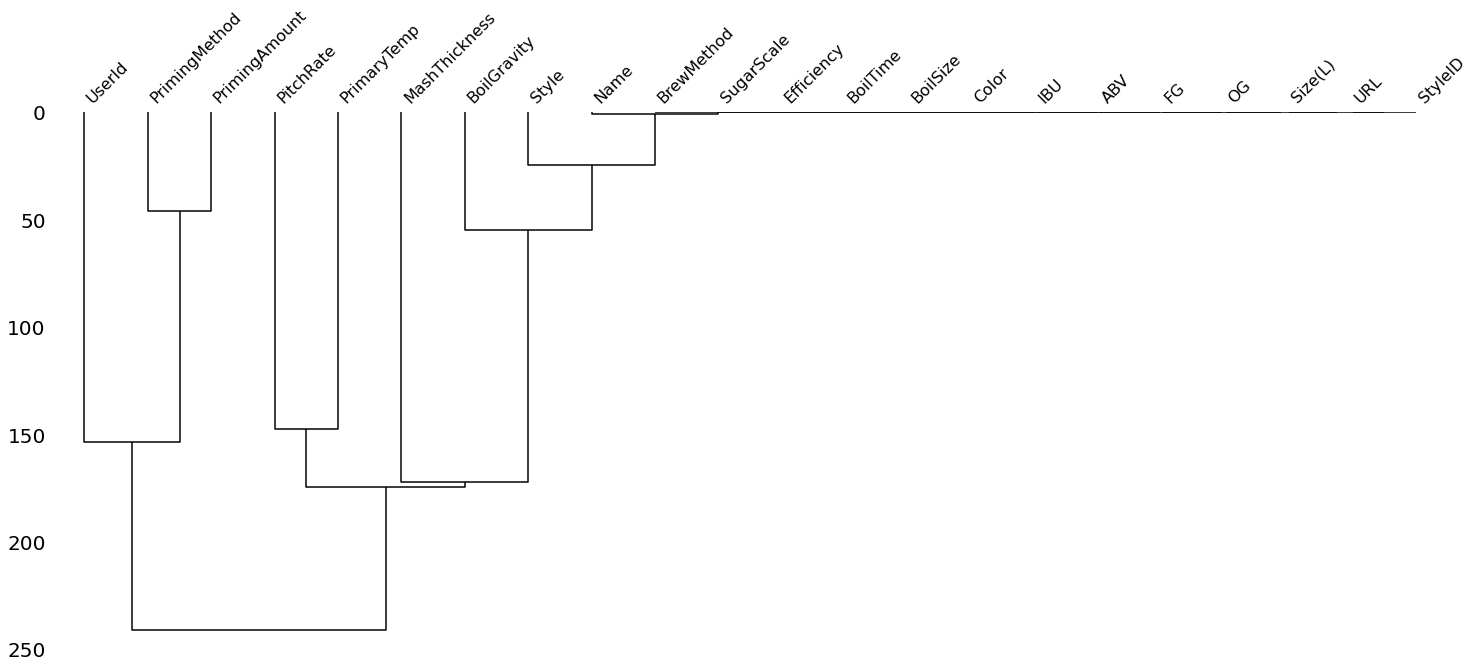

In [48]:
msno.dendrogram(df)

please see [this other notebook](https://github.com/PaoloMissier/CSC3831-2021-22/blob/main/IMPUTATION/KNN-iterativeImputer-example/KNN-Iterative-Beer.ipynb) for a continuation of this analysis, where KNN and MICE algorithms are used to improve our imputation.